In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from collate_full_catalog import collate_catalog
a_string = 'a_0.911185'
idx_tobs = np.where(scale_factor_array >= float(a_string[2:]))[0][0]
t_today = cosmic_age_array[idx_tobs]

history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 
                'stellar_mass', 'sfr', 'sfr_mp', 'sm_mp', 'a_first_infall')

histories = collate_catalog(a_string, history_colnames=history_colnames)
print("Number of galaxies = {0}".format(len(histories)))

... Assembling history data
Number of galaxies = 676555


In [4]:
from quenching_time import quenching_time
histories['quenching_time'] = quenching_time(histories['sfr_mp'], histories['sm_mp'])

In [5]:
histories['time_first_acc'] = np.interp(histories['a_first_infall'], scale_factor_array, cosmic_age_array)
histories['host_mpeak'] = histories['halo_mpeak']

In [6]:
from history_functions import ssfr_at_infall

histories['ssfr_at_infall'] = ssfr_at_infall(histories['sfr_mp'].data, 
                                histories['sm_mp'].data, histories['time_first_acc'].data)

In [7]:
satmask = (histories['gal_type'] == 'satellite') | (histories['gal_type'] == 'orphan')
sats = histories[satmask]
cenmask = histories['gal_type'] == 'central'
cens = histories[cenmask]

from halotools.utils import crossmatch
idxA, idxB = crossmatch(sats['halo_upid'], histories['halo_id'])
sats['host_mpeak'][idxA] = histories['halo_mpeak'][idxB]
histories['host_mpeak'][satmask] = sats['host_mpeak']

In [8]:
quenched_satmask = np.log10(sats['sfr']/sats['stellar_mass']) < -11
quenched_sats = sats[quenched_satmask]

quenched_cenmask = np.log10(cens['sfr']/cens['stellar_mass']) < -11
quenched_cens = cens[quenched_cenmask]

# Plot fraction that quenched after infall

In [9]:
logsm_low, logsm_high, num_sm_bins = 9., 11.35, 15
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

infall_time = np.zeros(len(sm_bins)-1)
infall_time_milky_way = np.zeros(len(sm_bins)-1)
infall_time_group = np.zeros(len(sm_bins)-1)
infall_time_cluster = np.zeros(len(sm_bins)-1)

infall_time_variance = np.zeros(len(sm_bins)-1)
infall_time_milky_way_variance = np.zeros(len(sm_bins)-1)
infall_time_group_variance = np.zeros(len(sm_bins)-1)
infall_time_cluster_variance = np.zeros(len(sm_bins)-1)

#
ssfr_at_infall = np.zeros(len(sm_bins)-1)
ssfr_at_infall_milky_way = np.zeros(len(sm_bins)-1)
ssfr_at_infall_group = np.zeros(len(sm_bins)-1)
ssfr_at_infall_cluster = np.zeros(len(sm_bins)-1)

ssfr_at_infall_variance = np.zeros(len(sm_bins)-1)
ssfr_at_infall_milky_way_variance = np.zeros(len(sm_bins)-1)
ssfr_at_infall_group_variance = np.zeros(len(sm_bins)-1)
ssfr_at_infall_cluster_variance = np.zeros(len(sm_bins)-1)


for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (sats['stellar_mass'] > sm_low) & (sats['stellar_mass'] < sm_high)
    infall_time[i] = np.mean(sats['time_first_acc'][sm_bin_mask])
    infall_time_variance[i] = np.std(sats['time_first_acc'][sm_bin_mask])
    ssfr_at_infall[i] = np.mean(sats['ssfr_at_infall'][sm_bin_mask])
    ssfr_at_infall_variance[i] = np.std(sats['ssfr_at_infall'][sm_bin_mask])
    
    milky_way_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[0])*(sats['host_mpeak'] < host_mass_bins[1])
    infall_time_milky_way[i] = np.mean(sats['time_first_acc'][milky_way_sm_bin_mask])
    infall_time_milky_way_variance[i] = np.std(sats['time_first_acc'][milky_way_sm_bin_mask])
    ssfr_at_infall_milky_way[i] = np.mean(sats['ssfr_at_infall'][milky_way_sm_bin_mask])
    ssfr_at_infall_milky_way_variance[i] = np.std(sats['ssfr_at_infall'][milky_way_sm_bin_mask])

    group_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[1])*(sats['host_mpeak'] < host_mass_bins[2])
    infall_time_group[i] = np.mean(sats['time_first_acc'][group_sm_bin_mask])
    infall_time_group_variance[i] = np.std(sats['time_first_acc'][group_sm_bin_mask])
    ssfr_at_infall_group[i] = np.mean(sats['ssfr_at_infall'][group_sm_bin_mask])
    ssfr_at_infall_group_variance[i] = np.std(sats['ssfr_at_infall'][group_sm_bin_mask])

    cluster_sm_bin_mask = sm_bin_mask*(sats['host_mpeak'] > host_mass_bins[2])*(sats['host_mpeak'] < host_mass_bins[3])
    infall_time_cluster[i] = np.mean(sats['time_first_acc'][cluster_sm_bin_mask])
    infall_time_cluster_variance[i] = np.std(sats['time_first_acc'][cluster_sm_bin_mask])
    ssfr_at_infall_cluster[i] = np.mean(sats['ssfr_at_infall'][cluster_sm_bin_mask])
    ssfr_at_infall_cluster_variance[i] = np.std(sats['ssfr_at_infall'][cluster_sm_bin_mask])

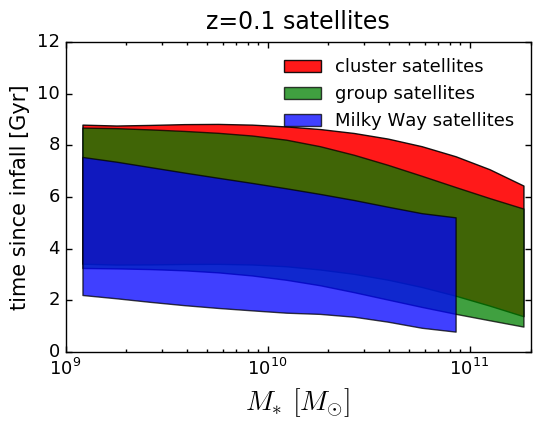

In [10]:
from scipy.signal import savgol_filter

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=20)
ylabel = ax.set_ylabel('time since infall [Gyr]', fontsize=15)
title = ax.set_title('z=0.1 satellites', fontsize=17, y=1.02) # y param fixes an overhanging title

# ax.plot(sm_mids, savgol_filter(t_today - infall_time_cluster, 13, 5), color='red', linewidth=2.5)
y1_cluster = savgol_filter(t_today - infall_time_cluster - infall_time_cluster_variance, 13, 5)
y2_cluster = savgol_filter(t_today - infall_time_cluster + infall_time_cluster_variance, 13, 5)
ax.fill_between(sm_mids, y1_cluster, y2_cluster, facecolor='red', alpha=0.9, label = "cluster satellites")

# ax.plot(sm_mids, savgol_filter(t_today - infall_time_group, 13, 5), color='green', linewidth=2.5)
y1_group = savgol_filter(t_today - infall_time_group - infall_time_group_variance, 13, 5)
y2_group = savgol_filter(t_today - infall_time_group + infall_time_group_variance, 13, 5)
ax.fill_between(sm_mids, y1_group, y2_group, facecolor='green', alpha=0.75, label = "group satellites")

last_idx = -2
# ax.plot(sm_mids[:last_idx], savgol_filter(t_today - infall_time_milky_way, 13, 5)[:last_idx], color='blue', linewidth=2.5)
y1_milky_way = savgol_filter(t_today - infall_time_milky_way - infall_time_milky_way_variance, 13, 5)[:last_idx]
y2_milky_way = savgol_filter(t_today - infall_time_milky_way + infall_time_milky_way_variance, 13, 5)[:last_idx]
ax.fill_between(sm_mids[:last_idx], y1_milky_way, y2_milky_way, facecolor='blue', alpha=0.75, 
               label = "Milky Way satellites")

plt.tick_params(axis='x', length=4, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=4, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = 0, ymax = 12)
plt.legend(frameon=False, loc='upper right', fontsize=13)

fig.savefig('FIGS/infall_time_comparison.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

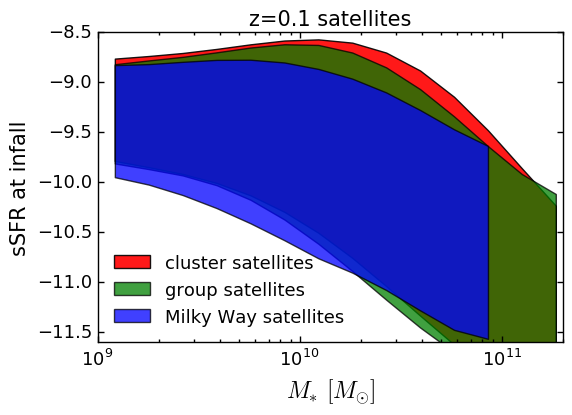

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=17)
ylabel = ax.set_ylabel(r'sSFR at infall', fontsize=15)
title = ax.set_title('z=0.1 satellites', fontsize=15, y=1.) # y param fixes an overhanging title

y1_cluster = savgol_filter(ssfr_at_infall_cluster - ssfr_at_infall_cluster_variance, 13, 5)
y2_cluster = savgol_filter(ssfr_at_infall_cluster + ssfr_at_infall_cluster_variance, 13, 5)
ax.fill_between(sm_mids, y1_cluster, y2_cluster, facecolor='red', alpha=0.9, label = "cluster satellites")

y1_group = savgol_filter(ssfr_at_infall_group - ssfr_at_infall_group_variance, 13, 5)
y2_group = savgol_filter(ssfr_at_infall_group + ssfr_at_infall_group_variance, 13, 5)
ax.fill_between(sm_mids, y1_group, y2_group, facecolor='green', alpha=0.75, label = "group satellites")

last_idx = -2
y1_milky_way = savgol_filter(ssfr_at_infall_milky_way - ssfr_at_infall_milky_way_variance, 13, 5)[:last_idx]
y2_milky_way = savgol_filter(ssfr_at_infall_milky_way + ssfr_at_infall_milky_way_variance, 13, 5)[:last_idx]
ax.fill_between(sm_mids[:last_idx], y1_milky_way, y2_milky_way, facecolor='blue', alpha=0.75, 
                label = "Milky Way satellites")

# ax.plot(sm_mids, savgol_filter(ssfr_at_infall_cluster, 13, 5), color='red', 
#         linewidth=2.5, label = "cluster satellites")
# ax.plot(sm_mids, savgol_filter(ssfr_at_infall_group, 13, 5), color='green', 
#         linewidth=2.5, label = "group satellites")
# ax.plot(sm_mids[:last_idx], savgol_filter(ssfr_at_infall_milky_way, 13, 5)[:last_idx], color='blue', 
#         linewidth=2.5, label = "Milky Way satellites")

# ax.plot(np.logspace(8, 13, 100), np.zeros(100)-11, '--', color='k')

plt.tick_params(axis='x', length=4, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=4, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = -11.6, ymax = -8.5)
plt.legend(frameon=False, loc='lower left', fontsize=13)

fig.savefig('FIGS/ssfr_at_infall_comparison.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Calculate quenching delay time

In [12]:
logsm_low, logsm_high, num_sm_bins = 9., 11.35, 15
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

delay_time = np.zeros(len(sm_bins)-1)
delay_time_milky_way = np.zeros(len(sm_bins)-1)
delay_time_group = np.zeros(len(sm_bins)-1)
delay_time_cluster = np.zeros(len(sm_bins)-1)

delay_time_variance = np.zeros(len(sm_bins)-1)
delay_time_milky_way_variance = np.zeros(len(sm_bins)-1)
delay_time_group_variance = np.zeros(len(sm_bins)-1)
delay_time_cluster_variance = np.zeros(len(sm_bins)-1)

for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (quenched_sats['stellar_mass'] > sm_low) & (quenched_sats['stellar_mass'] < sm_high)
    delay_time[i] = np.mean(quenched_sats['quenching_time'][sm_bin_mask] - quenched_sats['time_first_acc'][sm_bin_mask])
    delay_time_variance[i] = np.std(quenched_sats['quenching_time'][sm_bin_mask] - quenched_sats['time_first_acc'][sm_bin_mask])

    milky_way_sm_bin_mask = (quenched_sats['host_mpeak'] > host_mass_bins[0])*(quenched_sats['host_mpeak'] < host_mass_bins[1])
    milky_way_sm_bin_mask *= sm_bin_mask
    delay_time_milky_way[i] = np.mean(quenched_sats['quenching_time'][milky_way_sm_bin_mask] -
        quenched_sats['time_first_acc'][milky_way_sm_bin_mask])
    delay_time_milky_way_variance[i] = np.std(quenched_sats['quenching_time'][milky_way_sm_bin_mask] -
        quenched_sats['time_first_acc'][milky_way_sm_bin_mask])

    group_sm_bin_mask = (quenched_sats['host_mpeak'] > host_mass_bins[1])*(quenched_sats['host_mpeak'] < host_mass_bins[2])
    group_sm_bin_mask *= sm_bin_mask
    delay_time_group[i] = np.mean(quenched_sats['quenching_time'][group_sm_bin_mask] -
        quenched_sats['time_first_acc'][group_sm_bin_mask])
    delay_time_group_variance[i] = np.std(quenched_sats['quenching_time'][group_sm_bin_mask] -
        quenched_sats['time_first_acc'][group_sm_bin_mask])

    cluster_sm_bin_mask = (quenched_sats['host_mpeak'] > host_mass_bins[2])*(quenched_sats['host_mpeak'] < host_mass_bins[3])
    cluster_sm_bin_mask *= sm_bin_mask
    delay_time_cluster[i] = np.mean(quenched_sats['quenching_time'][cluster_sm_bin_mask] -
        quenched_sats['time_first_acc'][cluster_sm_bin_mask])
    delay_time_cluster_variance[i] = np.std(quenched_sats['quenching_time'][cluster_sm_bin_mask] -
        quenched_sats['time_first_acc'][cluster_sm_bin_mask])


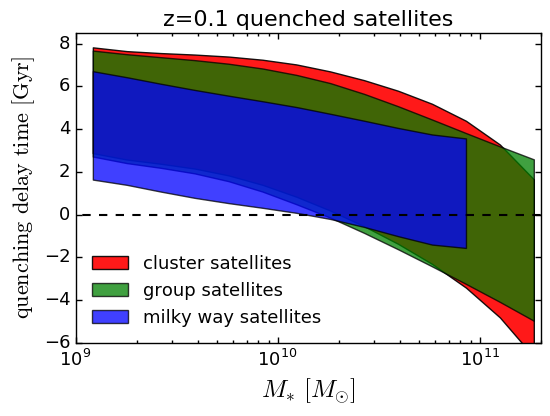

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=18)
ylabel = ax.set_ylabel(r'${\rm quenching}$ ${\rm delay}$ ${\rm time}$ ${\rm [Gyr]}$', fontsize=16)
title = ax.set_title('z=0.1 quenched satellites', fontsize=16, y=1) # y param fixes an overhanging title

y1_cluster = savgol_filter(delay_time_cluster - delay_time_cluster_variance, 13, 5)
y2_cluster = savgol_filter(delay_time_cluster + delay_time_cluster_variance, 13, 5)
ax.fill_between(sm_mids, y1_cluster, y2_cluster, facecolor='red', alpha=0.9, label = "cluster satellites")

y1_group = savgol_filter(delay_time_group - delay_time_group_variance, 13, 5)
y2_group = savgol_filter(delay_time_group + delay_time_group_variance, 13, 5)
ax.fill_between(sm_mids, y1_group, y2_group, 
                facecolor='green', alpha=0.75, label = "group satellites")

idx_last = -2
y1_milky_way = savgol_filter(delay_time_milky_way - delay_time_milky_way_variance, 13, 5)[:idx_last]
y2_milky_way = savgol_filter(delay_time_milky_way + delay_time_milky_way_variance, 13, 5)[:idx_last]
ax.fill_between(sm_mids[:idx_last], y1_milky_way, y2_milky_way, 
                facecolor='blue', alpha=0.75, label="milky way satellites")

ax.plot(np.logspace(8, 12, 100), np.zeros(100), '--', color='k')

plt.tick_params(axis='x', length=4, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=4, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = -6, ymax = 8.5)
plt.legend(frameon=False, loc='lower left', fontsize=13)

fig.savefig('FIGS/quenching_delay_time_comparison.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Now exclude negative delay times, as in Wetzel+

In [14]:
import matching_infall_times
reload(matching_infall_times)

<module 'matching_infall_times' from 'matching_infall_times.pyc'>

In [15]:
logsm_low, logsm_high, num_sm_bins = 9., 11.35, 15
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

wetzel_delay_time = np.zeros(len(sm_bins)-1)
wetzel_delay_time_milky_way = np.zeros(len(sm_bins)-1)
wetzel_delay_time_group = np.zeros(len(sm_bins)-1)
wetzel_delay_time_cluster = np.zeros(len(sm_bins)-1)

wetzel_delay_time_cens_cluster = np.zeros(len(sm_bins)-1)
wetzel_delay_time_cens_group = np.zeros(len(sm_bins)-1)
wetzel_delay_time_cens_milky_way = np.zeros(len(sm_bins)-1)

wetzel_delay_time_variance = np.zeros(len(sm_bins)-1)
wetzel_delay_time_milky_way_variance = np.zeros(len(sm_bins)-1)
wetzel_delay_time_group_variance = np.zeros(len(sm_bins)-1)
wetzel_delay_time_cluster_variance = np.zeros(len(sm_bins)-1)

wetzel_qsats = quenched_sats[quenched_sats['quenching_time']>=quenched_sats['time_first_acc']]


for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (wetzel_qsats['stellar_mass'] > sm_low) & (wetzel_qsats['stellar_mass'] < sm_high)
    wetzel_delay_time[i] = np.mean(wetzel_qsats['quenching_time'][sm_bin_mask] - wetzel_qsats['time_first_acc'][sm_bin_mask])
    wetzel_delay_time_variance[i] = np.std(wetzel_qsats['quenching_time'][sm_bin_mask] - wetzel_qsats['time_first_acc'][sm_bin_mask])

    sm_bin_cenmask = (quenched_cens['stellar_mass'] > sm_low) & (quenched_cens['stellar_mass'] < sm_high)
    quenched_cen_sm_sample = quenched_cens[sm_bin_cenmask]

    milky_way_sm_bin_mask = (wetzel_qsats['host_mpeak'] > host_mass_bins[0])*(wetzel_qsats['host_mpeak'] < host_mass_bins[1])
    milky_way_sm_bin_mask *= sm_bin_mask
    wetzel_delay_time_milky_way[i] = np.mean(wetzel_qsats['quenching_time'][milky_way_sm_bin_mask] -
        wetzel_qsats['time_first_acc'][milky_way_sm_bin_mask])
    wetzel_delay_time_milky_way_variance[i] = np.std(wetzel_qsats['quenching_time'][milky_way_sm_bin_mask] -
        wetzel_qsats['time_first_acc'][milky_way_sm_bin_mask])

    central_infall_times_milky_way = matching_infall_times.matching_infall_times(
        wetzel_qsats['time_first_acc'][milky_way_sm_bin_mask], len(quenched_cen_sm_sample))
    positive_cenmask = quenched_cen_sm_sample['quenching_time'] >= central_infall_times_milky_way
    wetzel_delay_time_cens_milky_way[i] = np.mean(quenched_cen_sm_sample['quenching_time'][positive_cenmask] - 
                                       central_infall_times_milky_way[positive_cenmask])

    group_sm_bin_mask = (wetzel_qsats['host_mpeak'] > host_mass_bins[1])*(wetzel_qsats['host_mpeak'] < host_mass_bins[2])
    group_sm_bin_mask *= sm_bin_mask
    wetzel_delay_time_group[i] = np.mean(wetzel_qsats['quenching_time'][group_sm_bin_mask] -
        wetzel_qsats['time_first_acc'][group_sm_bin_mask])
    wetzel_delay_time_group_variance[i] = np.std(wetzel_qsats['quenching_time'][group_sm_bin_mask] -
        wetzel_qsats['time_first_acc'][group_sm_bin_mask])

    central_infall_times_group = matching_infall_times.matching_infall_times(
        wetzel_qsats['time_first_acc'][group_sm_bin_mask], len(quenched_cen_sm_sample))
    positive_cenmask = quenched_cen_sm_sample['quenching_time'] >= central_infall_times_group
    wetzel_delay_time_cens_group[i] = np.mean(quenched_cen_sm_sample['quenching_time'][positive_cenmask] - 
                                       central_infall_times_group[positive_cenmask])

    cluster_sm_bin_mask = (wetzel_qsats['host_mpeak'] > host_mass_bins[2])*(wetzel_qsats['host_mpeak'] < host_mass_bins[3])
    cluster_sm_bin_mask *= sm_bin_mask
    wetzel_delay_time_cluster[i] = np.mean(wetzel_qsats['quenching_time'][cluster_sm_bin_mask] -
        wetzel_qsats['time_first_acc'][cluster_sm_bin_mask])
    wetzel_delay_time_cluster_variance[i] = np.std(wetzel_qsats['quenching_time'][cluster_sm_bin_mask] -
        wetzel_qsats['time_first_acc'][cluster_sm_bin_mask])

    central_infall_times_cluster = matching_infall_times.matching_infall_times(
        wetzel_qsats['time_first_acc'][cluster_sm_bin_mask], len(quenched_cen_sm_sample))
    positive_cenmask = quenched_cen_sm_sample['quenching_time'] >= central_infall_times_cluster
    wetzel_delay_time_cens_cluster[i] = np.mean(quenched_cen_sm_sample['quenching_time'][positive_cenmask] - 
                                       central_infall_times_cluster[positive_cenmask])

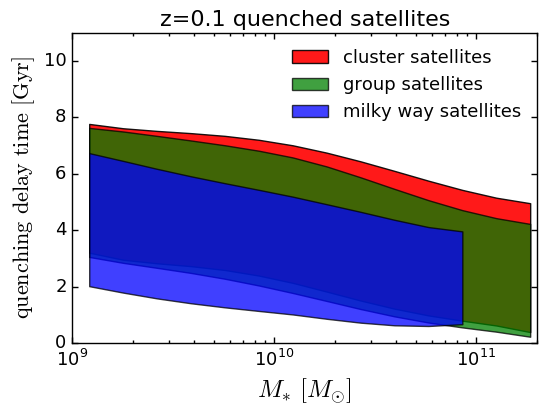

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=18)
ylabel = ax.set_ylabel(r'${\rm quenching}$ ${\rm delay}$ ${\rm time}$ ${\rm [Gyr]}$', fontsize=16)
title = ax.set_title('z=0.1 quenched satellites', fontsize=16, y=1) # y param fixes an overhanging title

y1_cluster = savgol_filter(wetzel_delay_time_cluster - wetzel_delay_time_cluster_variance, 13, 5)
y2_cluster = savgol_filter(wetzel_delay_time_cluster + wetzel_delay_time_cluster_variance, 13, 5)
ax.fill_between(sm_mids, y1_cluster, y2_cluster, facecolor='red', alpha=0.9, label = "cluster satellites")

y1_group = savgol_filter(wetzel_delay_time_group - wetzel_delay_time_group_variance, 13, 5)
y2_group = savgol_filter(wetzel_delay_time_group + wetzel_delay_time_group_variance, 13, 5)
ax.fill_between(sm_mids, y1_group, y2_group, 
                facecolor='green', alpha=0.75, label = "group satellites")

idx_last = -2
y1_milky_way = savgol_filter(wetzel_delay_time_milky_way - wetzel_delay_time_milky_way_variance, 13, 5)[:idx_last]
y2_milky_way = savgol_filter(wetzel_delay_time_milky_way + wetzel_delay_time_milky_way_variance, 13, 5)[:idx_last]
ax.fill_between(sm_mids[:idx_last], y1_milky_way, y2_milky_way, 
                facecolor='blue', alpha=0.75, label="milky way satellites")

# ax.plot(sm_mids, wetzel_delay_time_cluster, color='red')
# ax.plot(sm_mids, wetzel_delay_time_group, color='green')
# ax.plot(sm_mids[:idx_last], wetzel_delay_time_milky_way[:idx_last], color='blue')

# ax.plot(sm_mids[:idx_last], wetzel_delay_time_cens_milky_way[:idx_last], '--', color='blue',linewidth=2)
# ax.plot(sm_mids, wetzel_delay_time_cens_group, '--', color='green', linewidth=2)
# ax.plot(sm_mids, wetzel_delay_time_cens_cluster, '--', color='red', linewidth=2)
# ax.plot(np.logspace(8, 12, 100), np.zeros(100), '--', color='k')

plt.tick_params(axis='x', length=4, width=1, which='major') 
plt.tick_params(axis='x', length=2, width=1, which='minor') 
plt.tick_params(axis='y', length=4, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(xmin = 10**9, xmax=2*10**11)
plt.ylim(ymin = 0, ymax = 11)
plt.legend(frameon=False, loc='upper right', fontsize=13)

fig.savefig('FIGS/wetzel_quenching_delay_time_comparison.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [17]:
print(wetzel_delay_time_cens_cluster - wetzel_delay_time_cluster)

[ 0.78519523  0.83784923  0.87838369  0.88789983  0.9881785   0.9531971
  0.9622683   0.98365744  1.15137021  1.28332413  1.1924403   1.03741442
  1.03287404  1.20209812]


In [18]:
print(wetzel_delay_time_cens_milky_way - wetzel_delay_time_milky_way)

[ 0.55073131  0.6493585   0.59939004  0.62104928  0.64077482  0.58674808
  0.55720012  0.62753865  0.58571443  0.67892414  0.56699991  0.66694191
  0.38393951  0.78972109]
